In [ ]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'
from IPython.lib.display import YouTubeVideo

# Week 07 (Monday), AST 8581 / PHYS 8581 / CSCI 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>


with contributions totally ripped off from Gautham Narayan (UIUC), Michael Steinbach (UMN), and Nico Adams (UMN)

# Where do we stand?

Foundations of Data and Probability -> Statistical frameworks (Frequentist vs Bayesian) -> Estimating underlying distributions -> Analysis of Time series (periodicity) -> Analysis of Time series (variability) -> Analysis of Time series (stochastic processes) -> Gaussian Processes

# Last Class: Stochastic Processes and Correlation Functions

# Today: so if you have a correlation function, how do you get to $y(t)$? Gaussian Processes!


A stochastic process is collection of variables drawn from _a probability distribution over functions_.

In other words, if our function of interest is $y(t)$, a stochastic process assigns probabilities $P\left[y(t)\right]$.

## Gaussian Processes are examples of Model "free" models - aka "non-parametric models"


Sometimes we simply don't have a good first-principles model for what's going on in our data, but we're also confident that making a simple assumption (e.g. Gaussian scatter) is dead wrong.

### What does "model-free" mean?

In these situations, we're motivated to avoid strong modeling assumptions and instead be more empirical.

Common adjectives:
* non-parametric
* model-independent
* data-driven
* empirical

(Strictly speaking, these tend to correspond to models with very many parameters, but the terminology persists.)

Gaussian processes appear to be "non-parametric" because the algebraic evaluation of the posterior PDF includes analytic marginalization over all the (nuisance) parameters in the model (the true values of $y$ at each $x_{\rm obs}$).

As with all non-parametric models, GPs are not "assumption-free" or "model-independent": they are just not _simply_ or _physically_ parametrized, and so involve different _types_ of assumptions.

The trade-off between simply-parametrized and non-parametric models is between _interpretability_ (typically high for simply-parametrized physical models) and _prediction accuracy_ (typically high for non-parametric models).

### Gaussian Processes

A Gaussian process has the property that

$P\left[y(x) | y(x_1), y(x_2), \ldots\right]$

is a Gaussian depending on the $x_i$ and $y(x_i)$. The process is specified by a "mean function" $\mu(x)$ and a "covariance function" $C(x)$, or "kernel," which determines how quickly $y(x)$ can vary.

* A Gaussian process is a collection of random variables indexed by time or space for which every linear combination of those random variables has a multivariate normal distribution. 

* Because the distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, it is a distribution over functions with a continuous domain, e.g. time or space.

* We use a measure of the similarity between points (the kernel/covariance function) to predict the value for an unseen point from training data. The prediction is not just an estimate for that point, but also has uncertainty information—it is a one-dimensional Gaussian distribution. For multi-output predictions, multivariate Gaussian processes are used, for which the multivariate Gaussian distribution is the marginal distribution at each point.

* For some kernel functions, matrix algebra can be used to calculate the predictions. Otherwise, optimisation software is typically used to fit a Gaussian process model.

### Some Brief Theory
Let our samples be $x_i, y_i$, $i \in [0,n]$, then the probability of value $\hat{y}_i$ at position $x_i$ given the noisy $y_i$ is:
$$ Pr(Y_i = \hat{y}_i | y_i) = \mathcal{N}(\hat{y}_i; y_i,\sigma) = \frac{1}{\sqrt{2\pi}\sigma}\exp\left(\frac{-(y_i - \hat{y}_i)^2}{2\sigma^2}\right) $$

If we assume that every sample is **independent** of the other (which they may not be!), then the probability becomes trivially a **multivariate Gaussian distribution** (also known as a joint Gaussian distribution) with diagonal covariance
$$ \mathbf{Y} \sim \prod_i Pr(Y_i = \hat{y}_i | y_i, \sigma) = \mathcal{N}(\mathbf{\hat{y}}; \mathbf{y},\sigma I)$$

Following this idea, we model the $\mathbf{Y}$ random vector as a Multivariate Gaussian Distribution

$$\mathcal{N}\left( \mathbf{\hat{y}}; \boldsymbol{\mu},\Sigma \right) = \frac{1}{\sqrt{(2\pi )^{k}|\Sigma}|} \exp\left(-\frac{1}{2}(\boldsymbol{\mu} - \mathbf{\hat{y}})^{\mathrm{T}}\Sigma^{-1}(\boldsymbol{\mu} - \mathbf{\hat{y}})\right)$$

where $\Sigma_{ij}$ is a value that indicates how the sample $i$ varies with respect to $j$. 

$$\Sigma_{ij}={\rm cov}(y_i,y_j)$$

We don't have a parameteric model for $y$ anymore, but that's OK, we can write down a parametric model for the covariance itself. If we interpret this model as an stochastic **process** (i.e., $x$ represent time) one would expect that samples that are closer to each other are more correlated than those that are far away, and that only depends on $x$, not $y$. One can define then a function $\Sigma_{ij} = K(x_i,x_j)$, called the **Kernel** (or covariance) function, that defines this covariance.

$$\mathrm{cov}(y(t),y(t'))=K(t,t') $$

That's helpful to do, because with finite observations:

$$
\mathrm{cov}(y_i,y_j)=K(t_i,t_j)
$$

We will code up a few conditional distributions, based on different covariance / kernel functions (as matrices).

## So we don't have parametrized model, but do have parametrized covariance - what can we do with this thing?

## The prior

Now consider a finite set of observations: inputs $\boldsymbol{t}$, with corresponding outputs $\boldsymbol{y}$.

The *joint distribution* of $\boldsymbol{y}$ given $\boldsymbol{t}$, $m$ and $k$ is

### $$
\mathrm{p}(\boldsymbol{y} \mid \boldsymbol{t},m,k) = \mathcal{N}( \boldsymbol{m},K),
$$

where again, $\boldsymbol{m}=m(\boldsymbol{t})$ is the *mean vector* 

and $K$ is the *covariance matrix*, with elements $K_{ij} = k(t_i,t_j)$.

Note, there isn't one single function, but infinitely many for a specific choice of $m$, $k$. We marginalize over them to find the posterior mean. The parameters of $m$ and $k$ are called "hyper parameters". The interesting bit here is the covariance function/kernel, $k$ (we can always recenter the data to have mean = 0).

## Test and training sets

Suppose we have an (observed) *training set* $(\boldsymbol{t},\boldsymbol{y})$. 

We are interested in some other *test set* of inputs $\boldsymbol{t}_*$.

The joint distribution over the training and test sets is
### $$
\mathrm{p} \left( \left[ \begin{array}{l} \boldsymbol{y} \\ \boldsymbol{y}_* \end{array} \right] \right) 
= \mathcal{N} \left( \left[ \begin{array}{l} \boldsymbol{m} \\ \boldsymbol{m}_* \end{array} \right], 
\left[ \begin{array}{ll} K & K_* \\ K_*^T & K_{**} \end{array} \right] \right),
$$

where $\boldsymbol{m}_* = m(\boldsymbol{x}_*)$, $K_{**,ij} = k(t_{*,i},t_{*,j})$ and $K_{*,ij} = k(t_i,t_{*,j})$. 

This is not really any different from when we just had two observations:

### $$
\left[ \begin{array}{l} y_1 \\ y_2 \end{array} \right] \sim \mathcal{N} \left(
\left[ \begin{array}{l} \mu_1 \\ \mu_2 \end{array}  \right] , 
\left[ \begin{array}{ll} 
\sigma_1^2 & C \\
C & \sigma_2^2 
\end{array}  \right] 
\right),
$$

# For notational brevity I'm going to set the mean to 0.

## The conditional distribution

The *conditional distribution* for the test set given the training set is:

### $$ 
\mathrm{p} ( \boldsymbol{y}_* \mid \boldsymbol{y},k) = \mathcal{N} ( 
K_*^T K^{-1} \boldsymbol{y}, K_{**} - K_*^T K^{-1} K_* ).
$$

This is also just a straight forward generalization from what we had with just two points:

### $$
p(y_2 \mid y_1) = \mathcal{N} \left( \mu_2 + C (y_1-\mu_1)/\sigma_1^2, \sigma_2^2-C^2\sigma_1^2 \right).
$$

This is called the **predictive distribution**, because it can be use to predict future (or past) observations. 

More generally, it can be used for *interpolating* the observations to any desired set of inputs. 

This is one of the most widespread applications of GPs in some fields (e.g. kriging in geology, economic forecasting, ...)

## Real observations always contain a component of *white noise*

We need to account for this, but don't necessarily want to include in the predictions. 


If the white noise variance $\sigma^2$ is constant, we can write 

### $$
\mathrm{cov}(y_i,y_j)=k(t_i,t_j)+\delta_{ij} \sigma^2,
$$


and the conditional distribution becomes


### $$ 
\mathrm{p} ( \boldsymbol{y}_* \mid \boldsymbol{y},k) = \mathcal{N} ( 
K_*^T (K + \sigma^2 \mathbb{I})^{-1} \boldsymbol{y}, K_{**} - K_*^T (K + \sigma^2 \mathbb{I})^{-1} K_* ).
$$


We assumed constant white noise, but it's trivial to allow for different $\sigma$ for each data point.

You could also add some intrinsic dispersion as you often have to do. 

In real life, we may need to learn $\sigma_{\text{int}}$ from the data, alongside the other contribution to the covariance matrix.

## Single-point prediction

Let us look more closely at the predictive distribution for a single test point $t_*$.

It is a Gaussian with mean:
### $$
\overline{y}_* = \boldsymbol{k}_*^T (K + \sigma^2 \mathbb{I})^{-1} \boldsymbol{y}
$$

and variance
### $$
\mathbb{V}[y_*] = k(t_*,t_*) - \boldsymbol{k}_*^T (K + \sigma^2 \mathbb{I})^{-1} \boldsymbol{k}_*,
$$
where $\boldsymbol{k}_*$ is the vector of covariances between the test point and the training points.

Notice the mean is a linear combination of the observations: the GP is a *linear predictor*.

It is also a linear combination of covariance functions, each centred on a training point:

### $$
\overline{y}_* = \sum_{i=1}^N \alpha_i k(x_i,x_*),
$$
where $\alpha_i = (K + \sigma^2 \mathbb{I})^{-1} y_i$

# In-class warm-up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics

np.random.seed(2)
def f(x):
    """The function to predict."""
    return x * np.sin(x)

<ErrorbarContainer object of 3 artists>

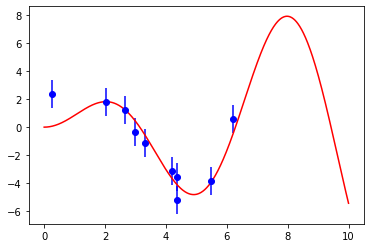

In [2]:
xmax = 10
X_space = np.linspace(0.001, xmax - 0.001, 1000)

# Get the "real" value
y_real = f(X_space)

n = 10
# Uniform sampling and add Gaussian noise
x_sample = np.random.random(n)*10

sigma = 1.0
noise = np.random.normal(0, sigma, n)
y_meas = f(x_sample) + noise

plt.plot(X_space,y_real,"r")
plt.errorbar(x_sample,y_meas,yerr=sigma,fmt="bo")

What do you understand the purpose of X_space is here?

In the real world we just have the data and we want to predict a new value (in this case, at $x_p$ = 5).


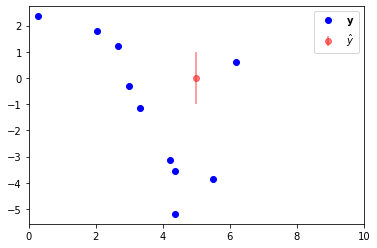

In [3]:
sigma = 1.0
y_p = 0.0
x_p = 5.0
plt.plot(x_sample,y_meas,"bo",label="$\mathbf{y}$")
plt.errorbar(x_p,y_p,yerr=sigma,fmt="ro",label="$\hat{y}$",alpha=0.5)
plt.legend()
plt.xlim(0,10)
ylim=plt.ylim()

We need to adopt a Kernel function. We will use an Exponential Quadratic Kernel here:
$$ \Sigma_{ij} = K(x_j,x_i) = \sigma^2 \exp\left(-\frac{(x_j - x_i)^2}{2\mathcal{l}^2} \right)$$

What does this metric look like in space?

In [4]:
x_comb = np.append(x_p,x_sample)

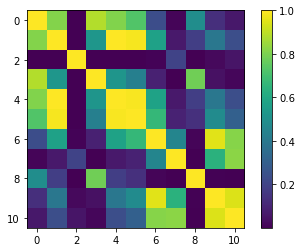

In [5]:
l = 1.0
X = np.atleast_2d(x_comb).T
M=sklearn.metrics.pairwise_distances(X,X)
S=sigma*sigma*np.exp(M*M/(-2*l*l))
plt.imshow(S)
plt.colorbar()

How do you intepret the elements on the diagonal? Off the diagonal?

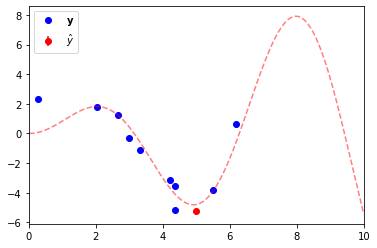

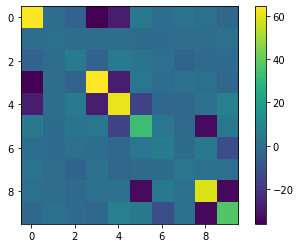

In [9]:
a = S[0,0]
b = S[0,1:]
C = S[1:,1:]
Cinv = np.linalg.inv(C)

lamb = 0.01
Cinv = np.linalg.inv(C + lamb*np.eye(C.shape[0],C.shape[1]))
mu_p = b.dot(Cinv).dot(y_meas)
sig_p = a - b.dot(Cinv).dot(b)
plt.plot(x_sample,y_meas,"bo",label="$\mathbf{y}$")
plt.errorbar(x_p,mu_p,yerr=sig_p,fmt="ro",label="$\hat{y}$")
plt.legend()
plt.xlim(0,10)
ylim=plt.ylim()
plt.plot(X_space,y_real,"r--",alpha=0.5)

plt.figure()
plt.imshow(Cinv)
plt.colorbar()

What do you understand $C^{-1}$ encodes here?

We tried another one (a Periodic Kernel) here:

$K(x,x') = \sigma^2 exp\left(−\frac{2 sin^2\left(\frac{\pi(x− x′)}{p}\right)}{l^2}\right)$


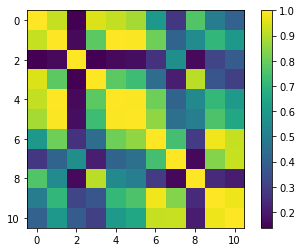

In [11]:
l = 1.0
p = 10.0
X = np.atleast_2d(x_comb).T
M=sklearn.metrics.pairwise_distances(X,X)
S=sigma*sigma*np.exp(2*np.sin(np.pi*M/p)*np.sin(np.pi*M/p)/(-l*l))
plt.imshow(S)
plt.colorbar()

In [ ]:
a = S[0,0]
b = S[0,1:]
C = S[1:,1:]
Cinv = np.linalg.inv(C)

lamb = 0.01
Cinv = np.linalg.inv(C + lamb*np.eye(C.shape[0],C.shape[1]))
# YOUR CODE HERE: see Single Point Prediction above
mu_p = b.dot(...
sig_p = a - b.dot(...
plt.plot(x_sample,y_meas,"bo",label="$\mathbf{y}$")
plt.errorbar(x_p,mu_p,yerr=sig_p,fmt="ro",label="$\hat{y}$")
plt.legend()
plt.xlim(0,10)
ylim=plt.ylim()
plt.plot(X_space,y_real,"r--",alpha=0.5)

plt.figure()
plt.imshow(Cinv)
plt.colorbar()

We tried (yet) another one (a Periodic + Exponential Kernel) here:

$K(x,x') = \sigma^2 exp\left(−\frac{2 sin^2\left(\frac{\pi(x− x′)}{p}\right)}{l^2}\right) \sigma^2 exp\left(-\frac{(x_j - x_i)^2}{2\mathcal{l}^2} \right) $

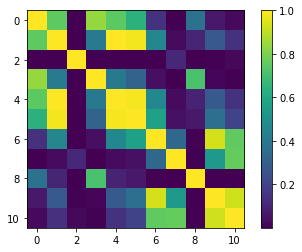

In [13]:
l = 1.0
p = 10.0
X = np.atleast_2d(x_comb).T
M=sklearn.metrics.pairwise_distances(X,X)
S=sigma*sigma*np.exp(2*np.sin(np.pi*M/p)*np.sin(np.pi*M/p)/(-l*l))*np.exp(M*M/(-2*l*l))
plt.imshow(S)
plt.colorbar()

In [ ]:
a = S[0,0]
b = S[0,1:]
C = S[1:,1:]
Cinv = np.linalg.inv(C)

lamb = 0.01
Cinv = np.linalg.inv(C + lamb*np.eye(C.shape[0],C.shape[1]))
# YOUR CODE HERE: see Single Point Prediction above
mu_p = b.dot(...
sig_p = a - b.dot(...
plt.plot(x_sample,y_meas,"bo",label="$\mathbf{y}$")
plt.errorbar(x_p,mu_p,yerr=sig_p,fmt="ro",label="$\hat{y}$")
plt.legend()
plt.xlim(0,10)
ylim=plt.ylim()
plt.plot(X_space,y_real,"r--",alpha=0.5)

plt.figure()
plt.imshow(Cinv)
plt.colorbar()

# Some astronomical applications

#### Spitzer exoplanet transits and eclipses (Evans et al. 2015)

<img src="figures/Evans_Spitzer.png" width="800">

#### GPs to deal with correlated noise in fitting spectra (Narayan et al., 2019)

<img src="figures/GP_spectra.jpg" width="800">

## Example: Mauna Kea CO$_2$ dataset

(From Rasmussen & Williams textbook)

<img height="700" src="figures/RW_mauna_kea.png">

#### GPz photometric redshifts (Almosallam, Jarvis & Roberts 2016)

<img src="figures/Almosallam_GPz.png" width="600">

# How do I choose the kernel/covariance function for a Gaussian process? 

Taken from: http://www.cs.toronto.edu/~duvenaud/cookbook/index.html

The choice of kernel/covariance function determines almost all the generalization properties of a GP model. You are the expert on your modeling problem - so you're the person best qualified to choose the kernel! If you don't yet know enough about kernels to choose a sensible one, read on.

### Radial Basis Function kernel (known also as the Gaussian kernel). It has the form:
$k_{SE}(x,x′) = \sigma^{2} \exp(−\frac{(x−x′)^2}{2l})$

<img src="figures/se_kernel.png" width="200"> <img src="figures/se_kernel_draws_s1.png" width="200">

Also called the "Exponentiated Quadratic". The SE kernel has become the de-facto default kernel for GPs and SVMs. This is probably because it has some nice properties. It is universal, and you can integrate it against most functions that you need to. Every function in its prior has infinitely many derivatives. 

It also has only two parameters: 

* the lengthscale l determines the length of the 'wiggles' in your function. In general, you won't be able to extrapolate more than l units away from your data.
* the output variance $\sigma^2$ determines the average distance of your function away from its mean. Every kernel has this parameter out in front; it's just a scale factor.

###  Rational Quadratic Kernel
$k_{RQ}(x,x′) = \sigma^{2} (1 + \frac{(x−x′)^2}{2 \alpha l^2})^{-\alpha}$

<img src="figures/rq_kernel.png" width="200"> <img src="figures/rq_kernel_draws.png" width="200">

This kernel is equivalent to adding together many SE kernels with different lengthscales. So, GP priors with this kernel expect to see functions which vary smoothly across many lengthscales. The parameter $\alpha$ determines the relative weighting of large-scale and small-scale variations. When $\alpha$ goes to $\infty$, the RQ is identical to the SE.

#### Pitfalls of the SE and RQ kernels
Most people who set up a GP regression or classification model end up using the Squared-Exp or Rational Quadratic kernels. They are a quick-and-dirty solution that will probably work pretty well for interpolating smooth functions when N is a multiple of D, and when there are no 'kinks' in your function. If your function happens to have a discontinuity or is discontinuous in its first few derivatives (for example, the abs() function), then either your lengthscale will end up being extremely short, and your posterior mean will become zero almost everywhere, or your posterior mean will have 'ringing' effects. Even if there are no hard discontinuities, the lengthscale will usually end up being determined by the smallest 'wiggle' in your function - so you might end up failing to extrapolate in smooth regions if there is even a small non-smooth region in your data.

If your data is more than two-dimensional, it may be hard to detect this problem. One indication is if the lengthscale chosen by maximum marginal likelihood never stops becoming smaller as you add more data. This is a classic sign of model misspecification.

### Periodic Kernel
$k_Per(x,x′) = \sigma^{2} \exp(\frac{-2 \sin^2 (\pi |x−x′| /p)}{l^2})$

<img src="figures/per_kernel.png" width="200"> <img src="figures/per_kernel_draws_s2.png" width="200">

The periodic kernel (derived by David Mackay) allows one to model functions which repeat themselves exactly. Its parameters are easily interpretable:

* The period p simply determines the distnace between repititions of the function.
* The lengthscale l determines the lengthscale function in the same way as in the SE kernel.


###  Locally Periodic Kernel

A SE kernel times a periodic results in functions which are periodic, but which can slowly vary over time.

$k_LocalPer(x,x′) = \sigma^{2} \exp(\frac{-2 \sin^2 (\pi |x−x′| /p)}{l^2}) \exp(−\frac{(x−x′)^2}{2l})$

<img src="figures/longse_times_per.png" width="200"> <img src="figures/longse_times_per_draws_s1.png" width="200">

Most periodic functions don't repeat themselves exactly. To add some flexibility to our model, we can consider adding or multiplying a local kernel such as the squared-exp with our periodic kernel. This will allow us to model functions that are only locally periodic - the shape of the repeating part of the function can now change over time.

### Linear Kernel

$kLin(x,x′)= \sigma_b^2 + \sigma_v^2(x-c)(x′-c)$

<img src="figures/lin_kernel.png" width="200"> <img src="figures/lin_kernel_draws_s2.png" width="200">

If you use just a linear kernel in a GP, you're simply doing Bayesian linear regression, and good news! You can do this in time O(N) instead of O(N3), so you should probably go use software specifically designed for that.

We include the linear kernel here because further on, we'll show you how to combine it with other kernels in order to get some nice properties.

The linear kernel is not like the others in that it's non-stationary. A stationary covariance function is one that only depends on the relative position of its two inputs, and not on their absolute location. That means that the parameters of the linear kernel are about specifying the origin:

* The offset c determines the x-coordinate of the point that all the lines in the posterior go though. At this point, the function will have zero variance (unless you add noise)
* The constant variance $\sigma_b^2$ determines how far from 0 the height of the function will be at zero. It's a little confusing, becuase it's not specifying that value directly, but rather putting a prior on it. It's equivalent to adding an uncertain offset to our model. See What about the mean function?

### Combining Kernels

The kernels above are useful if your data is all the same type, but what if you have more than one type of feature, but you still want to regress on all of them together? The standard way to build a kernel over different datatypes is to multiply kernels together.

### Multiplying Kernels
Multiplying together kernels is the standard way to combine two kernels, especially if they are defined on different inputs to your function.
Roughly speaking, multiplying two kernels can be thought of as an AND operation. That is, if you multiply together two kernels, then the resulting kernel will have high value only if both of the two base kernels have a high value. Here are a few examples, in addition to the squared-exp times periodic above:


#### Linear times Periodic
A linear kernel times a periodic results in functions which are periodic with increasing amplitude as we move away from the origin.

<img width="200" src="figures/lin_times_per.png"> <img width="200" src="figures/lin_times_per_draws_s2.png">

#### Linear times Linear
A linear kernel times another linear kernel results in functions which are quadratic! This trick can be taken to produce Bayesian polynomial regression of any degree.

<img width="200" src="figures/lin_times_lin.png"> <img width="200" src="figures/lin_times_lin_draws_s7.png">

### Multidimensional Products
Multiplying two kernels which each depend only on a single input dimension results in a prior over functions that vary across both dimesions. That is, the function value f(x,y) is only expected to be similar to some other function value f(x′,y′) if x is close to x′ AND y is close to y′.

These kernels have the form: $kproduct(x,y,x′,y′)=kx(x,x′)ky(y,y′)$

<img width="600" src="figures/Sqaured-exp kernel in 2d.png">

Here we show both a multimensional product kernel, and a draw from the corresponding GP prior:


### Adding kernels
Roughly speaking, adding two kernels can be thought of as an OR operation. That is, if you add together two kernels, then the resulting kernel will have high value if either of the two base kernels have a high value.

#### Linear plus Periodic

<img width="200" src="figures/lin_plus_per.png"> <img width="200" src="figures/lin_plus_per_draws_s2.png">

A linear kernel plus a periodic results in functions which are periodic with increasing mean as we move away from the origin.

### Automatically Choosing a Kernel
After reading all this advice, you might decide that you're not sure which kernel is approriate for your problem. In fact, you might decide that choosing the kernel is one of the main difficulties in doing inference - and just as you don't know what the true parameters are, you also don't know what the true kernel is. Probably, you should try out a few different kernels at least, and compare their marginal likelihood on your training data.

However, it might be annoying to write down all the different kernels you want to try, especially if there are more than a few variations you're interested in. If want to let the computer run a search over kernels for you, we've made code available to do just that. We wrote about these automatic searches in a paper.

### Further Reading
There is a massive literature about kernels for Gaussian process and SVMs. Probably the most comprehensive collection of information about covariance functions for Gaussian processes is chapter 4 of the book Gaussian Processes for Machine Learning. Another practical guide with lots of examples (and example code!) is in the documentation for the python GPy library. 

# In-class exercise: Gaussian Process on Cepheids
Let's generate a simple Cepheids-like dataset: observations of $y$ with reported uncertainties $\sigma_y$, at given $x$ values.

In [37]:
# RUN THIS

import numpy as np
import pylab as plt

xlimits = [0,350]
ylimits = [0,250]

def generate_data(seed=None):
    """
    Generate a 30-point data set, with x and sigma_y as standard, but with
    y values given by

    y = a_0 + a_1 * x + a_2 * x**2 + a_3 * x**3 + noise
    """
    Ndata = 30

    xbar = 0.5*(xlimits[0] + xlimits[1])
    xstd = 0.25*(xlimits[1] - xlimits[0])

    if seed is not None:
        np.random.seed(seed=seed)

    x = xbar + xstd * np.random.randn(Ndata)

    meanerr = 0.025*(xlimits[1] - xlimits[0])

    sigmay = meanerr + 0.3 * meanerr * np.abs(np.random.randn(Ndata))

    a = np.array([37.2,0.93,-0.002,0.0])
    y = a[0] + a[1] * x + a[2] * x**2 + a[3] * x**3 + sigmay*np.random.randn(len(x))

    return x,y,sigmay

def plot_yerr(x, y, sigmay):
    """
    Plot an (x,y,sigma) dataset as a set of points with error bars 
    """
    plt.errorbar(x, y, yerr=sigmay, fmt='.', ms=7, lw=1, color='k')
    plt.xlabel('$x$', fontsize=16)
    plt.ylabel('$y$', fontsize=16)
    plt.xlim(*xlimits)
    plt.ylim(*ylimits)
    return

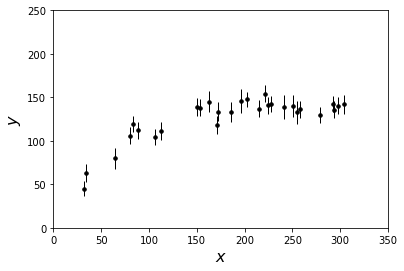

In [38]:
(x, y, sigmay) = generate_data(seed=13)

plot_yerr(x, y, sigmay)

## Fitting the Gaussian Process

In [39]:
# RUN THIS
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF as SquaredExponential

### Defining the kernel/covariance Function

As you know by now, we need to define a kernel/covariance function, for populating the covariance matrix of our GP. 

We will use a Gaussian kernel/covariance (also referred to as a "squared exponential" or a "radial basis function" RBF). The squared exponential kernel has one hyper-parameter, the length scale that is the Gaussian width.

In [40]:
h = 10.0

kernel = SquaredExponential(length_scale=h, length_scale_bounds=(0.01, 1000.0))
gp0 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

Now, let's draw some samples from the unconstrained process, o equivalently, the prior. Each sample is a function $y(x)$, which we evaluate on a grid. We'll need to assert a value for the kernel hyperparameter $h$, which dictates the correlation length between the datapoints. That will allow us to compute a mean function (which for simplicity we'll set to the mean observed $y$ value), and a covariance matrix that captures the correlations between datapoints.

In [ ]:
np.random.seed(1)
xgrid = np.atleast_2d(np.linspace(0, 399, 100)).T
print("y(x) will be predicted on a grid of length", len(xgrid))

# Draw three sample y(x) functions:
draws = gp0.sample_y(...

print("Drew 3 samples, stored in an array with shape ", draws.shape)

Let's plot these, to see what our prior looks like.


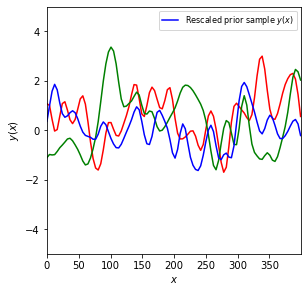

In [42]:
# Start a 4-panel figure:
fig = plt.figure(figsize=(10,10))

# Plot our three prior draws:
ax = fig.add_subplot(221)
ax.plot(xgrid, draws[:,0], '-r')
ax.plot(xgrid, draws[:,1], '-g')
ax.plot(xgrid, draws[:,2], '-b', label='Rescaled prior sample $y(x)$')
ax.set_xlim(0, 399)
ax.set_ylim(-5, 5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y(x)$')
ax.legend(fontsize=8);

Each predicted $y(x)$ is drawn from a Gaussian of unit variance, and with off-diagonal elements determined by the covariance function. 

Try changing `h` to see what happens to the smoothness of the predictions. 

> Go back up to the cell where `h` is assigned, and re-run that cell and the subsequent ones.

For our data to be well interpolated by this Gaussian Process, it will need to be rescaled such that it has zero mean and unit variance. There are [standard methods for doing this](http://scikit-learn.org/stable/modules/preprocessing.html), but we'll do this rescaling here for transparency - and so we know what to add back in later!

In [43]:
class Rescale():
    def __init__(self, y, err):
        self.original_data = y
        self.original_err = err
        self.mean = np.mean(y)
        self.std = np.std(y)
        self.transform()
        return
    def transform(self):
        self.y = (self.original_data - self.mean) / self.std
        self.err = self.original_err / self.std
        return()
    def invert(self, scaled_y, scaled_err):
        return (scaled_y * self.std + self.mean, scaled_err * self.std)     

In [ ]:
rescaled = Rescale(y, sigmay)
print('Mean, variance of original data: ',np.round(np.mean(y)), np.round(np.var(y)))
print('Mean, variance of rescaled data: ',np.round(np.mean(rescaled.y)), np.round(np.var(rescaled.y)))

In [ ]:
y2, sigmay2 = rescaled.invert(rescaled.y, rescaled.err)
print('Mean, variance of inverted, rescaled data: ',np.round(np.mean(y2)), np.round(np.var(y2)))
print('Maximum differences in y, sigmay, after round trip: ',np.max(np.abs(y2 - y)), np.max(np.abs(sigmay2 - sigmay)))

### Constraining the GP

Now, using the same covariance function, lets "fit" the GP by constraining each draw from the GP to go through our data points, and _optimizing_ the length scale hyperparameter `h`. 

Let's first look at how this would work for two data points with no uncertainty. 

In [ ]:
# Choose two of our (rescaled) datapoints:
x1 = np.array([x[10], x[12]])
rescaled_y1 = np.array([rescaled.y[10], rescaled.y[12]])
rescaled_sigmay1 = np.array([rescaled.err[10], rescaled.err[12]])

# Instantiate a GP model, with initial length_scale h=10:
kernel = SquaredExponential(...
gp1 = GaussianProcessRegressor(...

# Fit it to our two noiseless datapoints:
gp1.fit(...

# We have fit for the length scale parameter: print the result here:
params = gp1.kernel_.get_params()
print('Best-fit kernel length scale =', params['length_scale'],'cf. input',10.0)

# Now predict y(x) everywhere on our xgrid: 
rescaled_ygrid1, rescaled_ygrid1_err = gp1.predict(...

# And undo scaling, of both y(x) on our grid, and our two constraining data points:
ygrid1, ygrid1_err = rescaled.invert(...
y1, sigmay1 = rescaled.invert(...

In [ ]:
ax = fig.add_subplot(222)
ax.plot(xgrid, ygrid1, '-', color='gray', label='Posterior mean $y(x)$')
ax.fill(np.concatenate([xgrid, xgrid[::-1]]),
        np.concatenate([(ygrid1 - ygrid1_err), (ygrid1 + ygrid1_err)[::-1]]),
        alpha=0.3, fc='gray', ec='None', label='68% confidence interval')
ax.plot(x1, y1, '.k', ms=6, label='Noiseless constraints')
ax.set_xlim(0, 399)
ax.set_ylim(0, 399)
ax.set_xlabel('$x$')
fig

In the absence of information, the GP tends to produce $y(x)$ that fluctuate around the prior mean function, which we chose to be a constant. Let's draw some samples from the posterior PDF, and overlay them.

In [ ]:
draws = gp1.sample_y(xgrid, n_samples=3)
for k in range(3):
    draws[:,k], dummy = rescaled.invert(draws[:,k], np.zeros(len(xgrid)))

ax.plot(xgrid, draws[:,0], '-r')
ax.plot(xgrid, draws[:,1], '-g')
ax.plot(xgrid, draws[:,2], '-b', label='Posterior sample $y(x)$')
ax.legend(fontsize=8)
fig

See how the posterior sample $y(x)$ functions all pass through the constrained points.

In [ ]:
# Choose two of our datapoints:
x2 = np.array([x[10], x[12]])
rescaled_y2 = np.array([rescaled.y[10], rescaled.y[12]])
rescaled_sigmay2 = np.array([rescaled.err[10], rescaled.err[12]])

# Instantiate a GP model, including observational errors:
kernel = SquaredExponential(...
gp2 = GaussianProcessRegressor(...

# Fit it to our two noisy datapoints:
gp2.fit(...

# We have fit for the length scale parameter: print the result here:
params = gp2.kernel_.get_params()
print('Best-fit kernel length scale =', params['length_scale'],'cf. input',10.0)

# Now predict y(x) everywhere on our xgrid: 
rescaled_ygrid2, rescaled_ygrid2_err = gp2.predict(...

# And undo scaling:
ygrid2, ygrid2_err = rescaled.invert(...
y2, sigmay2 = rescaled.invert(...

# Draw three posterior sample y(x):
draws = gp2.sample_y(xgrid, n_samples=3)
for k in range(3):
    draws[:,k], dummy = rescaled.invert(draws[:,k], np.zeros(len(xgrid)))

In [ ]:
ax = fig.add_subplot(223)

def gp_plot(ax, xx, yy, ee, datax, datay, datae, samples, legend=True):
    ax.cla()
    ax.plot(xx, yy, '-', color='gray', label='Posterior mean $y(x)$')
    ax.fill(np.concatenate([xx, xx[::-1]]),
            np.concatenate([(yy - ee), (yy + ee)[::-1]]),
            alpha=0.3, fc='gray', ec='None', label='68% confidence interval')
    ax.errorbar(datax, datay, datae, fmt='.k', ms=6, label='Noisy constraints')
    ax.set_xlim(0, 399)
    ax.set_ylim(0, 399)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y(x)$')
    ax.plot(xgrid, samples[:,0], '-r')
    ax.plot(xgrid, samples[:,1], '-g')
    ax.plot(xgrid, samples[:,2], '-b', label='Posterior sample $y(x)$')
    if legend: ax.legend(fontsize=8)
    return

gp_plot(ax, xgrid, ygrid2, ygrid2_err, x2, y2, sigmay2, draws, legend=True)
fig

Now, the posterior sample $y(x)$ functions pass through the constraints _within the errors_.

### Using all the Data

Now let's extend the above example to use all of our datapoints. This additional information should pull the predictions further away from the initial mean function. We'll also compute the marginal log likelihood of the best fit hyperparameter, in case we want to compare this choice of kernel with another one (in the exercises, for example).

In [ ]:
# Use all of our datapoints:
x3 = x
rescaled_y3 = rescaled.y
rescaled_sigmay3 = rescaled.err

# Instantiate a GP model, including observational errors:
kernel = SquaredExponential(...
# Could comment this out, and then import and use an 
# alternative kernel here. 

gp3 = GaussianProcessRegressor(...

# Fit it to our noisy datapoints:
gp3.fit(...

# Now predict y(x) everywhere on our xgrid: 
rescaled_ygrid3, rescaled_ygrid3_err = gp3.predict(...

# And undo scaling:
ygrid3, ygrid3_err = rescaled.invert(...
y3, sigmay3 = rescaled.invert(...

# We have fitted the length scale parameter - print the result here:
params = gp3.kernel_.get_params()
print('Kernel: {}'.format(gp3.kernel_))
print('Best-fit kernel length scale =', params['length_scale'],'cf. input',10.0)
print('Marginal log-Likelihood: {:.3f}'.format(gp3.log_marginal_likelihood(gp3.kernel_.theta)))

# Draw three posterior sample y(x):
draws = gp3.sample_y(xgrid, n_samples=3)
for k in range(3): 
    draws[:,k], dummy = rescaled.invert(draws[:,k], np.zeros(len(xgrid)))

In [ ]:
ax = fig.add_subplot(224)

gp_plot(ax, xgrid, ygrid3, ygrid3_err, x3, y3, sigmay3, draws, legend=True)
fig

We now see the Gaussian Process model providing a smooth interpolation between the points. The posterior samples show fluctuations, but all are plausible under our assumptions.

# Appendix: Gaussian Process Theory

### Gaussian Processes in Data Analysis

A draw from $P[y(x^*)]$ would represent a prior prediction for the function value $y(x^*)$

Typically we are more interested in the posterior prediction, drawn from $P[y(x^*)\vert y^{\rm obs}(x_{\rm obs})]$

$$ \log L = - \log | \Sigma| - |y -u|^T \Sigma^{-1} |y-u|$$


$$ \Sigma = (n x n)\text{ matrix}$$ 

with 

$$ \Sigma_{i,j} = \text{Cov}(y(t_i), y(t_j)) = \int_{-\infty}^{\infty} \text{PSD} e^{2\pi if |t_i - t_j|} \,df $$


The posterior PDF for $y(x^*)$ is a Gaussian, whose mean and standard deviation can be computed algebraically, and which is constrained by _all the previously observed $y(x)$_.


<img src="figures/mfm_gp_example.png"> 

### GP Regression

GP's provide a natural way to achieve high flexibility (and uncertainty) when _interpolating_ data. 

With the appropriate assumptions (e.g. Gaussian measurement errors), the calculation of the posterior for $y(x)$ is an _algebraic_ operation (no Monte Carlo required).

Marginalization over the GP hyperparameters (the width of the kernel, for example) is more computationally expensive (involving the determinants of the matrices), but [fast methods have been developed](http://dan.iel.fm/george/current/user/hyper/).

During the first half of the semester, you got famililar with observations drawn from a distribution e.g. $y1$, drawn from a Gaussian distribution with mean $\mu$ and variance $\sigma^2$:

\begin{align}
p(y_1 | \mu, \sigma) = \frac{1}{\sqrt{2 \pi} \sigma} \exp \left[ - \frac{(y_1-\mu)^2}{2 \sigma^2} \right] 
\end{align}

i.e.

### $$y_1 \sim \mathcal{N}(\mu,\sigma^2)$$

If pair of variables $y_1$ and $y_2$, drawn from a *bivariate Gaussian distribution*. The *joint probability density* for $y_1$ and $y_2$ is:

### $$
\left[ \begin{array}{l} y_1 \\ y_2 \end{array} \right] \sim \mathcal{N} \left(
\left[ \begin{array}{l} \mu_1 \\ \mu_2 \end{array}  \right] , 
\left[ \begin{array}{ll} 
\sigma_1^2 & C \\
C & \sigma_2^2 
\end{array}  \right] 
\right),
$$

where 

### $$C = {\rm cov}(y_1,y_2)$$ 

is the *covariance* between $y_1$ and $y_2$.

In the first half of the semester, we dealt with independent variables i.e.

### $$P(y_1 \cap y_2) = P(y_1) \cdot P(y_2) $$

and consequently


\begin{align}
P(y_2|y_1) = \frac{P(y_1 \cap y_2)}{P(y_1)} = P(y_2)
\end{align}

If two variables are independent, then $C = 0$ (remember converse isn't true). 

The observations are *uncorrelated* so measuring $y_1$ doesn't teach us anything about $y_2$.

(If in addition $\mu_1 = \mu_2$ and $\sigma_1 = \sigma_2$ the variables are i.i.d)

### With time-series, $C \ne 0$ 

If we know the value of $y_1$, the probability density for $y_2$ collapses to the the *conditional distribution* of $y_2$ given $y_1$:

### $$
p(y_2 \mid y_1) = \mathcal{N} \left( \mu_2 + C (y_1-\mu_1)/\sigma_1^2, \sigma_2^2-C^2\sigma_1^2 \right).
$$

### Now consider $N$ variables drawn from a multivariate Gaussian distribution:

### $$
\boldsymbol{y} \sim \mathcal{N} (\boldsymbol{\mu},\boldsymbol{\Sigma})
$$

where 

### $$\boldsymbol{y} = (y_1,y_2,\ldots,y_N)^T$$

### $$\boldsymbol{\mu} = (\mu_1,\mu_2,\ldots,\mu_N)^T$$ 


is the *mean vector*, and $\boldsymbol{\Sigma}$ is an $N \times N$ positive semi-definite *covariance matrix*, with elements 

### $$\Sigma_{ij}={\rm cov}(y_i,y_j)$$

### And then the likelihood generalizes from 1D:

\begin{align}
p(y_1 | \mu, \sigma) = \frac{1}{\sqrt{2 \pi} \sigma} \exp \left[ - \frac{(y_1-\mu)^2}{2 \sigma^2} \right] 
\end{align}

### to ND:


\begin{align}
p(\boldsymbol{y} | \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{\sqrt{2 \pi^N |\Sigma|} } \exp \left[ -\frac{1}{2} (\boldsymbol{y} - \boldsymbol{\mu})^T \Sigma^{-1} (\boldsymbol{y} - \boldsymbol{\mu}) \right] 
\end{align}


This works because:

<img src="figures/gaussians_all_the_way_down.jpg">

## A Gaussian process is an extension of this concept to infinite $N$.

This gives rise to a probability distribution over functions, rather than finite $N$ samples. 

<img src="figures/gp.png">

Informally - infinitely long vector ~ function

Again, for finite number of $y$ drawn from a multivariate normal distribution:

### $$
\boldsymbol{y} \sim \mathcal{N} (\boldsymbol{\mu},\boldsymbol{\Sigma})
$$

This clearly doesn't make sense for infinite $N$, but the essential feature remains the same:
### A Gaussian process is completely specified by its *mean function* and *covariance function*.  

### Incorporating observational error is similar to what you did in the past as well:

### $$ y \sim f(t) + \epsilon$$ 

### with deviations from the truth related to the observational uncertainties

### $$ \epsilon \sim \mathcal{N}(0, \sigma_y^2) $$


### except now, $f(t)$ is a function not of some parameters, but rather of functions thenselves:

###  $$ f(t) \sim \mathcal{GP}(m(t), k(t,t'))$$

### where I'm switching from $\mu$ to $m(t)$ and $\Sigma$ to $k(t, t')$ just to make explicit that these are not vectors.

I'm using $k$ because this function that describes the covariance between time $t$ and $t'$ is called a **kernel** function. 

<img src="figures/random_process.jpg">

<img src="figures/weight_space.jpg">

<img src="figures/two_views.jpg">

# So how do you choose the kernel $k$?

Common choices: http://www.cs.toronto.edu/~duvenaud/cookbook/index.html

Lets fiddle:

# In-class exercise:

[Click this](https://distill.pub/2019/visual-exploration-gaussian-processes/)

## The likelihood

The *likelihood* of the data under the GP model is simply:

### $$
\mathrm{p}(\boldsymbol{y} \,|\, \boldsymbol{t}) = \mathcal{N}(\boldsymbol{y} \, | \, \boldsymbol{0},K + \sigma^2 \mathbb{I}).
$$

This is a measure of how well the model explains, or predicts, the training set.

i.e. **The observed $\boldsymbol{y}$ are noisy realisations of a latent (unobserved) Gaussian process $\boldsymbol{f}$.**

We are marginalizing over the function values $\boldsymbol{f}$:
### $$
\mathrm{p}(\boldsymbol{y} \,|\, \boldsymbol{t}) = \int \mathrm{p}(\boldsymbol{y} \,|\, \boldsymbol{f},\boldsymbol{t}) \, \mathrm{p}(\boldsymbol{f} \,|\, \boldsymbol{t}) \, \mathrm{d}\boldsymbol{f},
$$

where 


### $$
\mathrm{p}(\boldsymbol{f} \,|\, \boldsymbol{t}) = \mathcal{N}(\boldsymbol{f} \, | \, \boldsymbol{0},K)
$$


is the *prior*, and 


### $$
\mathrm{p}(\boldsymbol{y} \,|\, \boldsymbol{f},\boldsymbol{t}) = \mathcal{N}(\boldsymbol{y} \, | \, \boldsymbol{0},\sigma^2 \mathbb{I})
$$
is the *likelihood*.

# You "condition" the hyperparameters on some observed data

i.e. evaluate the conditional (or predictive) distribution for a given covariance matrix (i.e. covariance function and hyper-parameters), and training set.

## *Training* the GP...

...means maximising the *likelihood* of the model with respect to the hyperparameters.

## The kernel trick

Consider a linear basis model with arbitrarily many *basis functions*, or *features*, $\Phi(x)$, and a (Gaussian) prior $\Sigma_{\mathrm{p}}$ over the basis function weights. 

You end up with exactly the same expressions for the predictive distribution and the likelihood so long as:
### $$
k(\boldsymbol{x},\boldsymbol{x'}) = \Phi(\boldsymbol{x})^{\mathrm{T}} \Sigma_{\mathrm{p}} \Phi(\boldsymbol{x'}),
$$


or, writing $\Psi(\boldsymbol{x}) = \Sigma_{\mathrm{p}}^{1/2} \Phi(\boldsymbol{x})$,


### $$
k(\boldsymbol{x},\boldsymbol{x'}) = \Psi(\boldsymbol{x}) \cdot \Psi(\boldsymbol{x'}),
$$

Thus the covariance function $k$ enables us to go from a (finite) *input space* to a (potentially infinite) *feature space*. This is known as the *kernel trick* and the covariance function is often referred to as the *kernel*.

# Probabilistic Graphical Model for a GP


### Recall:

A **probabilistic graphical model** (PGM) is a very useful way of visualizing a generative model.
* They sketch out the procedure for how one would generate mock data in practice.
* They illustrate the interdependence of model parameters, and the dependence of data on parameters.
* _They also (therefore) represent a conditional factorization of the PDF for all the data and model parameters._

Ingredients of a PGM:
* **Nodes** represent PDFs for parameters
* **Edges** represent conditional relationships
* **Plates** represent repeated model components whose contents are **conditionally independent**

Types of nodes:
* **Circles** represent a PDF. This parameter is a *stochastic* function of the parameters feeding into it.
* **Points** represent a delta-function PDF. This parameter is a *deterministic* function of the parameters feeding into it.
* **Double circles** (or shading) indicate measured data. They are stochastic in the context of generating mock data, but fixed in the context of parameter inference.

# If we were dealing with i.i.d. data

### $$ y \sim f(t) + \epsilon$$ 

### with deviations from the truth related to the observational uncertainties

### $$ \epsilon \sim \mathcal{N}(0, \sigma_y^2) $$


<img src="figures/pgm_conditionally_independent.png">

# With time-series the data are not conditionally independent

i.e. you don't have a nice plate:

<img src="figures/gp_pgm.png">

From [Rasmussen & Williams (aka the GP bible)](http://www.gaussianprocess.org/gpml/chapters/RW.pdf)